# Johnson & Johnson Time Series Forecasting (ARIMA Model Case Study)

            Sales
date             
1960-01-01   0.71
1960-04-01   0.63
1960-07-02   0.85
1960-10-01   0.44
1961-01-01   0.61
Data shape: (84, 1)


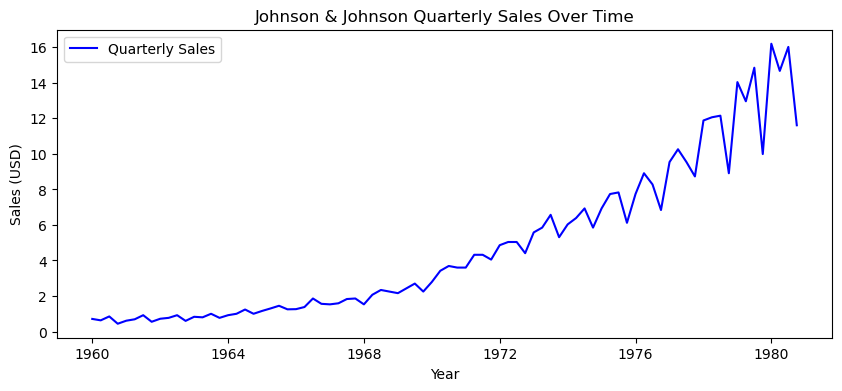

In [1]:
# Import Libraries and Load the Data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings('ignore')  # Ignore warnings for cleaner output

# Data Preparation
data = pd.read_csv('jj.csv', parse_dates=['date'])
data = data.set_index('date')
data = data.rename(columns={'data': 'Sales'})  # Renaming column
print(data.head())
print("Data shape:", data.shape)

# Visualize the Original Time Series
plt.figure(figsize=(10, 4))
plt.plot(data.index, data['Sales'], color='blue', label='Quarterly Sales')
plt.title('Johnson & Johnson Quarterly Sales Over Time')
plt.xlabel('Year')
plt.ylabel('Sales (USD)')
plt.legend()
plt.show()

# Stationarity Check (Augmented Dickey-Fuller Test)

In [2]:
# Stationarity Check (Augmented Dickey-Fuller Test)
result = adfuller(data['Sales'])
print(f"ADF Statistic: {result[0]:.3f}")
print(f"p-value: {result[1]:.3f}")

ADF Statistic: 2.742
p-value: 1.000


In [3]:
# Here, Data is non-stationary (p>0.05),fail to reject the null hypothesis of a unit root.
# i.e,the time series is non-stationary 

# Make the Series Stationary 

In [4]:
# Log Transformation and Differencing
log_sales = np.log(data['Sales'])
log_diff_sales = log_sales.diff().dropna()
result = adfuller(log_diff_sales)
print(f"ADF Statistic after 1st diff (log): {result[0]:.3f}")
print(f"p-value: {result[1]:.4f}")

ADF Statistic after 1st diff (log): -4.317
p-value: 0.0004


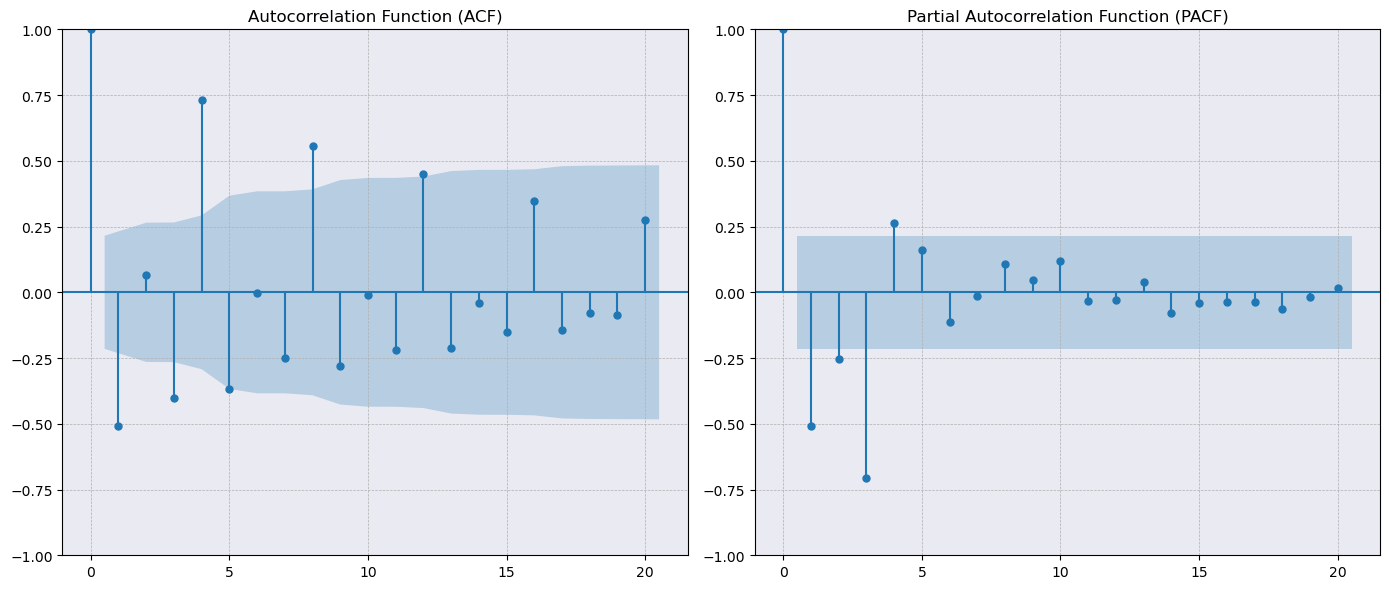

In [5]:
# Plot ACF and PACF with enhancements
plt.figure(figsize=(14, 6))  

# ACF plot
plt.subplot(121)
plot_acf(log_diff_sales, lags=20, ax=plt.gca(), title='Autocorrelation Function (ACF)')
plt.gca().set_facecolor('#EAEAF2') 
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid lines for better readability

# PACF plot
plt.subplot(122)
plot_pacf(log_diff_sales, lags=20, ax=plt.gca(), title='Partial Autocorrelation Function (PACF)')
plt.gca().set_facecolor('#EAEAF2')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()  
plt.show()

# ARIMA(p,d,q) Model 

In [6]:
# Manual Search for the Best ARIMA(p,d,q) Model Using AIC
def find_best_arima_model(time_series, max_p, max_d, max_q):
    best_aic = np.inf
    best_order = None
    # Iterate over combinations of p, d, q
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(time_series, order=(p, d, q))
                    model_fit = model.fit()
                    if model_fit.aic < best_aic:
                        best_aic = model_fit.aic
                        best_order = (p, d, q)
                except Exception as e:
                    continue
    return best_order, best_aic
# Find the best model based on AIC
best_order, best_aic = find_best_arima_model(log_sales, 7, 2, 7)
print(f"Best ARIMA Model: {best_order} with AIC: {best_aic:.2f}")

Best ARIMA Model: (4, 1, 3) with AIC: -144.20


In [7]:
# Model Fitting
arima_model = ARIMA(log_sales, order=best_order)
fitted_model = arima_model.fit()
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   84
Model:                 ARIMA(4, 1, 3)   Log Likelihood                  80.099
Date:                Thu, 10 Apr 2025   AIC                           -144.198
Time:                        17:18:55   BIC                           -124.847
Sample:                             0   HQIC                          -136.423
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0005      0.060     -0.009      0.993      -0.118       0.116
ar.L2          0.0137      0.049      0.279      0.780      -0.083       0.110
ar.L3          0.0272      0.048      0.565      0.5

In [8]:
# In-Sample Metrics
predictions = fitted_model.get_prediction(start=log_sales.index[0], dynamic=False)
predicted_values = np.exp(predictions.predicted_mean)
actual_values = data.loc[predictions.predicted_mean.index, 'Sales']

mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
print("\nIn-Sample Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


In-Sample Evaluation Metrics:
MAE: 0.28
MSE: 0.16
RMSE: 0.40
MAPE: 8.21%


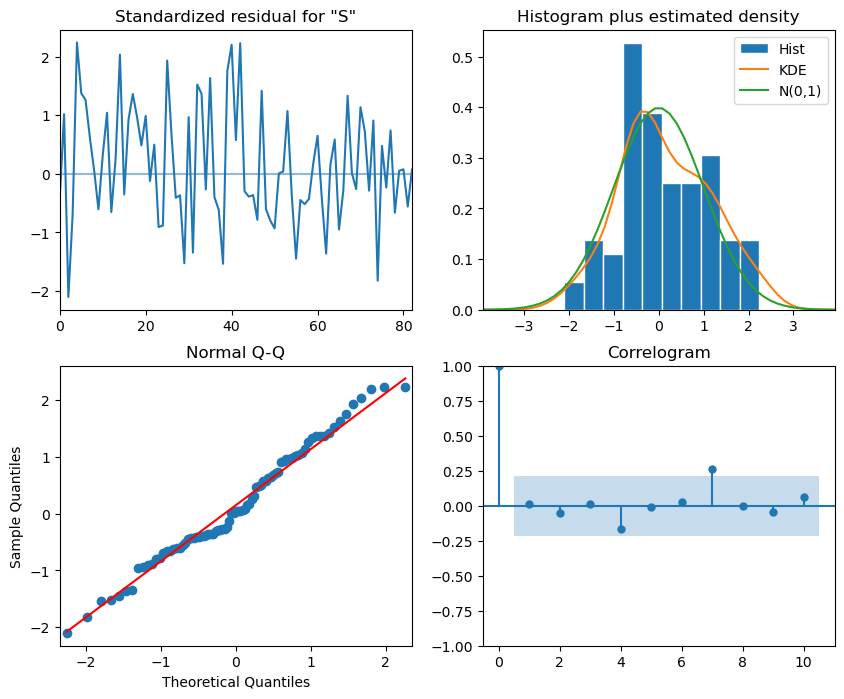

In [9]:
# Residual Diagnostics
fitted_model.plot_diagnostics(figsize=(10, 8))
plt.show()

# Forecast the Next 24 Months (8 Quarters)

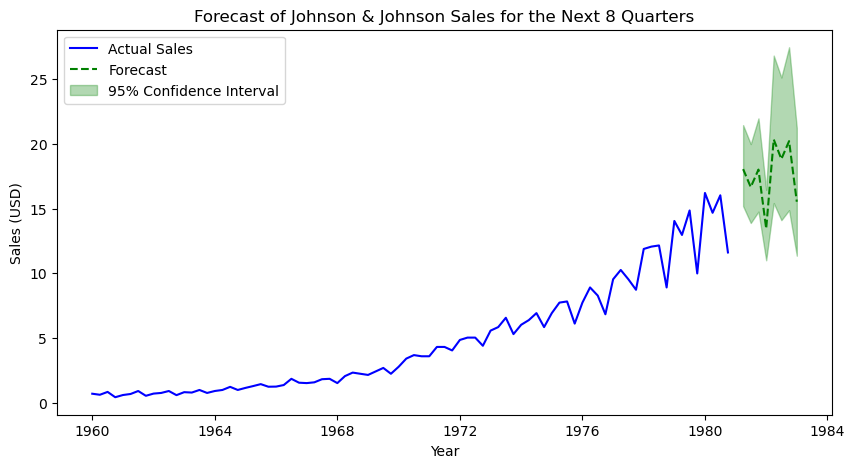

In [10]:
# Forecasting 8 Quarters Ahead
forecast_steps = 8  # Number of time periods to forecast
forecast_result = fitted_model.get_forecast(steps=forecast_steps)  # Generate forecast from the fitted model
forecast_log = forecast_result.predicted_mean  # Mean of the forecasted values in log scale
forecast_conf_int = forecast_result.conf_int()  # Confidence intervals for the forecast in log scale

# Convert the forecast and confidence intervals from log scale back to original scale
forecast_values = np.exp(forecast_log)  # Exponential to transform log to original scale
forecast_lower = np.exp(forecast_conf_int.iloc[:, 0])  # Lower bound of the 95% confidence interval
forecast_upper = np.exp(forecast_conf_int.iloc[:, 1])  # Upper bound of the 95% confidence interval

# Create a date range for the forecasted period for plotting purposes
forecast_index = pd.date_range(start='1981-01-01', periods=forecast_steps, freq='Q')

# Plotting the Forecast vs Original Series
plt.figure(figsize=(10, 5))  # Set the size of the figure
plt.plot(data.index, data['Sales'], label='Actual Sales', color='blue')  # Plot the actual sales data
plt.plot(forecast_index, forecast_values, label='Forecast', linestyle='--', color='green')  # Plot the forecasted values
plt.fill_between(forecast_index, forecast_lower, forecast_upper, color='green', alpha=0.3, label='95% Confidence Interval')  # Fill between the confidence intervals
plt.title('Forecast of Johnson & Johnson Sales for the Next 8 Quarters')  # Title of the plot
plt.xlabel('Year')  
plt.ylabel('Sales (USD)')
plt.legend(loc='upper left')  
plt.show()  

# Time Series Forecasting with LSTM and GRU on Johnson & Johnson Sales Data

Performance Metrics for LSTM and GRU Models:
MAE: LSTM = 1.62, GRU = 1.32
MSE: LSTM = 4.36, GRU = 2.36
RMSE: LSTM = 2.09, GRU = 1.54
MAPE: LSTM = 13.28, GRU = 10.32


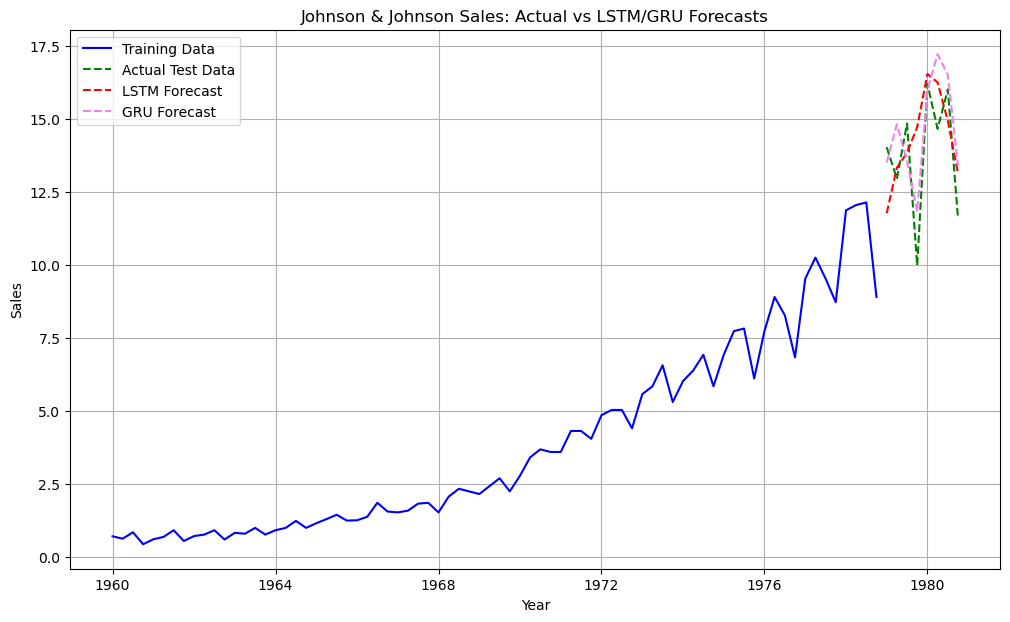

In [11]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import tensorflow as tf

def load_and_preprocess(filepath, num_test_samples=8):
    """
    Load the dataset and preprocess it by setting the date as the index.
    
    Parameters:
    - filepath (str): The path to the CSV file.
    - num_test_samples (int): The number of samples to be used for the test set.
    
    Returns:
    - train_series (pd.Series): The training data series.
    - test_series (pd.Series): The testing data series.
    - series_data (pd.Series): The complete data series.
    """
    data_frame = pd.read_csv(filepath, parse_dates=['date'])
    data_frame.set_index('date', inplace=True)
    series_data = data_frame['data']
    
    # Split into train and test sets
    train_series = series_data.iloc[:-num_test_samples]
    test_series = series_data.iloc[-num_test_samples:]
    
    return train_series, test_series, series_data

def transform_to_stationary(series):
    """
    Transform a series to stationary by applying log transformation and differencing.
    
    Parameters:
    - series (pd.Series): Time series data.
    
    Returns:
    - Tuple of log transformed data and differenced data.
    """
    log_transformed = np.log(series.values)
    differences = np.diff(log_transformed, n=1)
    return log_transformed, differences

def create_time_series_sequences(data, sequence_length):
    """
    Create sequences from time series data suitable for RNN models.
    
    Parameters:
    - data (np.array): Array of time series data (differenced and transformed).
    - sequence_length (int): The number of time steps per sequence.
    
    Returns:
    - X (np.array): The feature sequences.
    - y (np.array): The target sequences corresponding to the features.
    """
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

def build_lstm_or_gru_model(model_choice='lstm', sequence_length=8, neurons=50, activation_func='tanh'):
    """
    Build and compile an LSTM or GRU model based on specified parameters.
    
    Parameters:
    - model_choice (str): Choice between 'lstm' and 'gru'.
    - sequence_length (int): Number of time steps in each input sequence.
    - neurons (int): Number of neurons in the recurrent layer.
    - activation_func (str): Activation function to use in the recurrent layer.
    
    Returns:
    - Compiled Keras model ready for training.
    """
    model = Sequential()
    if model_choice.lower() == 'lstm':
        model.add(LSTM(neurons, activation=activation_func, input_shape=(sequence_length, 1)))
    elif model_choice.lower() == 'gru':
        model.add(GRU(neurons, activation=activation_func, input_shape=(sequence_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def recursive_forecasting(model, initial_sequence, initial_value_log, scaler, forecast_length=8, sequence_length=8):
    """
    Generate forecasts using the trained model in a recursive manner.
    
    Parameters:
    - model (Sequential): Trained LSTM or GRU model.
    - initial_sequence (np.array): Last known data sequence.
    - initial_value_log (float): Last known log value of the series.
    - scaler (StandardScaler): Scaler object used for scaling data.
    - forecast_length (int): Number of forecasts to generate.
    - sequence_length (int): Number of time steps in each input sequence.
    
    Returns:
    - predictions (np.array): Predicted values.
    """
    predictions = []
    sequence = scaler.transform(initial_sequence.reshape(-1, 1)).flatten()
    log_value = initial_value_log
    
    for _ in range(forecast_length):
        model_input = sequence.reshape(1, sequence_length, 1)
        predicted_diff = model.predict(model_input, verbose=0)[0, 0]
        reverse_diff = scaler.inverse_transform([[predicted_diff]])[0, 0]
        
        log_value += reverse_diff
        predictions.append(np.exp(log_value))
        sequence = np.append(sequence[1:], predicted_diff)
    
    return np.array(predictions)

def compute_performance_metrics(actual, predicted):
    """
    Compute and return performance metrics for the forecasts.
    
    Parameters:
    - actual (np.array): Actual values to compare against.
    - predicted (np.array): Model's predicted values.
    
    Returns:
    - Dictionary of calculated metrics including MAE, MSE, RMSE, and MAPE.
    """
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    return {
        'MAE': mean_absolute_error(actual, predicted),
        'MSE': mean_squared_error(actual, predicted),
        'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
        'MAPE': np.mean(np.abs((actual - predicted) / actual)) * 100
    }

def plot_forecasts(training_data, testing_data, forecast_data, model_labels):
    """
    Plot training, testing, and forecast data for visual comparison.
    
    Parameters:
    - training_data (pd.Series): Training series data.
    - testing_data (pd.Series): Testing series data.
    - forecast_data (list): List of forecast arrays.
    - model_labels (list): List of labels for each forecast model.
    """
    plt.figure(figsize=(12, 7))
    plt.plot(training_data.index, training_data, label='Training Data', color='blue')
    plt.plot(testing_data.index, testing_data, label='Actual Test Data', color='green', linestyle='--')
    
    colors = ['red', 'violet']
    for i, (label, forecast) in enumerate(zip(model_labels, forecast_data)):
        plt.plot(testing_data.index, forecast, label=f'{label} Forecast', color=colors[i], linestyle='--')
    
    plt.title('Johnson & Johnson Sales: Actual vs LSTM/GRU Forecasts')
    plt.xlabel('Year')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution flow
if __name__ == "__main__":
    filepath = "jj.csv"
    sequence_length = 8
    epochs = 100
    test_samples = 8
    
    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # Data loading and preprocessing
    train_data, test_data, full_series = load_and_preprocess(filepath, test_samples)
    log_data, diff_data = transform_to_stationary(train_data)
    X_train, y_train = create_time_series_sequences(diff_data, sequence_length)
    
    # Data scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    y_train_scaled = scaler.transform(y_train.reshape(-1, 1)).flatten()
    X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], sequence_length, 1))
    
    # Model building and training
    lstm_model = build_lstm_or_gru_model('lstm', sequence_length)
    gru_model = build_lstm_or_gru_model('gru', sequence_length)
    
    lstm_model.fit(X_train_scaled, y_train_scaled, epochs=epochs, verbose=0)
    gru_model.fit(X_train_scaled, y_train_scaled, epochs=epochs, verbose=0)
    
    # Forecasting
    initial_sequence = diff_data[-sequence_length:]
    initial_log_value = log_data[-1]
    
    lstm_predictions = recursive_forecasting(lstm_model, initial_sequence, initial_log_value, scaler, test_samples, sequence_length)
    gru_predictions = recursive_forecasting(gru_model, initial_sequence, initial_log_value, scaler, test_samples, sequence_length)
    
    # Performance evaluation
    lstm_metrics = compute_performance_metrics(test_data.values, lstm_predictions)
    gru_metrics = compute_performance_metrics(test_data.values, gru_predictions)
    
    print("Performance Metrics for LSTM and GRU Models:")
    for metric in ['MAE', 'MSE', 'RMSE', 'MAPE']:
        print(f"{metric}: LSTM = {lstm_metrics[metric]:.2f}, GRU = {gru_metrics[metric]:.2f}")
    
    # Visualization of results
    plot_forecasts(train_data, test_data, [lstm_predictions, gru_predictions], ['LSTM', 'GRU'])


# ARIMA Time Series Modeling for Amazon Stock Price (Monthly)

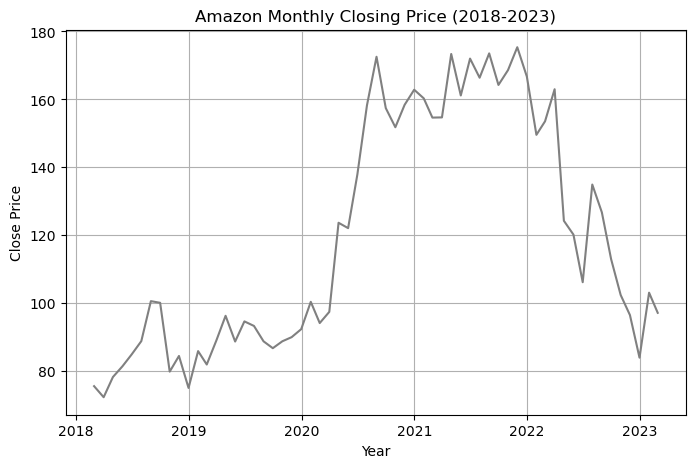

In [28]:
# Import Necessary Libraries
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Data Preparation
# Load the dataset
df = pd.read_csv('AMZN.csv', parse_dates=['Date'], index_col='Date')
# Resample to monthly frequency, taking the last closing price of each month
monthly_close = df['Close'].resample('M').last()


# Visualize the Monthly Closing Price 
#Plot Amazon Monthly Closing Price
plt.figure(figsize=(8,5))
plt.plot(monthly_close.index, monthly_close.values, color='grey')
plt.title('Amazon Monthly Closing Price (2018-2023)')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()


# Stationarity with Augmented Dickey-Fuller (ADF) Test

In [13]:
result = adfuller(monthly_close.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.5392301342169907
p-value: 0.5140232647833247


In [14]:
#p-value < 0.05
#The p-value ~ 0.51 is much greater than 0.05, 
#fail to reject the null hypothesis

#Make the Series Stationary – Log Transform and Differencing
# Log Transformation
log_close = np.log(monthly_close)
result_log = adfuller(log_close.dropna())
print("ADF Statistic (log):", result_log[0])
print("p-value (log):", result_log[1])


ADF Statistic (log): -1.6666161408109945
p-value (log): 0.4483896872175652


In [15]:
#After log transformation,still p > 0.05,log series remains non-stationary.
#First Differencing (on Log-Transformed Data)
diff_log_close = log_close.diff().dropna()  # 1st difference of log series
result_diff_log = adfuller(diff_log_close)
print("ADF Statistic (log diff):", result_diff_log[0])
print("p-value (log diff):", result_diff_log[1])

ADF Statistic (log diff): -8.920696772064435
p-value (log diff): 1.0430561375247622e-14


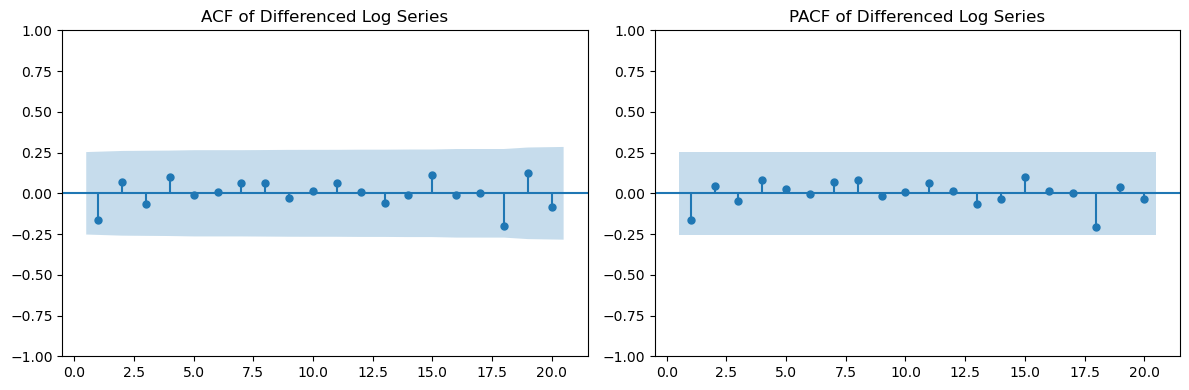

In [16]:
#After first differencing the log series, the p-value is essentially 0 (1.0e-14), which is far below 0.05.
#This means the differenced log series is stationary.

#Plot ACF and PACF of the Stationary Series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(diff_log_close, ax=plt.gca(), lags=20, zero=False)
plt.title('ACF of Differenced Log Series')
plt.subplot(1,2,2)
plot_pacf(diff_log_close, ax=plt.gca(), lags=20, zero=False)
plt.title('PACF of Differenced Log Series')
plt.tight_layout()
plt.show()

# ARMA Model Fit (p,d,q)

In [17]:
#Manual Grid Search for ARIMA(p,d,q) using AIC

def manual_grid_search_arima(data, max_p, max_q, d=1):
    """
    Perform a manual grid search to find the best ARIMA(p,d,q) model based on AIC.
    
    Parameters:
    data (pd.Series): The time series data on which to fit the ARIMA model.
    max_p (int): The maximum number of AR terms to consider.
    max_q (int): The maximum number of MA terms to consider.
    d (int): The order of differencing (default is 1).
    
    Returns:
    tuple: Best ARIMA model order and the corresponding AIC.
    """
    warnings.filterwarnings("ignore")  # Ignore convergence warnings for some models
    best_aic = np.inf
    best_order = None
    
    for p in range(max_p + 1):  # range starts at 0 and includes max_p
        for q in range(max_q + 1):  # range starts at 0 and includes max_q
            try:
                model = ARIMA(data, order=(p, d, q))
                res = model.fit()
                print(f"ARIMA({p},{d},{q}) AIC: {res.aic:.2f}")
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_order = (p, d, q)
            except Exception as e:
                print(f"Failed to fit ARIMA({p},{d},{q}): {str(e)}")
                continue
    
    print(f"Best model by AIC: ARIMA{best_order} with AIC={best_aic:.2f}")
    return best_order, best_aic


best_order, best_aic = manual_grid_search_arima(log_close, max_p=6, max_q=6)


ARIMA(0,1,0) AIC: -107.97
ARIMA(0,1,1) AIC: -107.40
ARIMA(0,1,2) AIC: -105.61
ARIMA(0,1,3) AIC: -103.69
ARIMA(0,1,4) AIC: -102.42
ARIMA(0,1,5) AIC: -100.42
ARIMA(0,1,6) AIC: -98.44
ARIMA(1,1,0) AIC: -107.56
ARIMA(1,1,1) AIC: -105.99
ARIMA(1,1,2) AIC: -104.02
ARIMA(1,1,3) AIC: -102.07
ARIMA(1,1,4) AIC: -100.42
ARIMA(1,1,5) AIC: -98.42
ARIMA(1,1,6) AIC: -97.01
ARIMA(2,1,0) AIC: -105.73
ARIMA(2,1,1) AIC: -104.02
ARIMA(2,1,2) AIC: -102.08
ARIMA(2,1,3) AIC: -100.26
ARIMA(2,1,4) AIC: -98.83
ARIMA(2,1,5) AIC: -96.73
ARIMA(2,1,6) AIC: -97.36
ARIMA(3,1,0) AIC: -103.89
ARIMA(3,1,1) AIC: -102.08
ARIMA(3,1,2) AIC: -100.20
ARIMA(3,1,3) AIC: -98.68
ARIMA(3,1,4) AIC: -96.93
ARIMA(3,1,5) AIC: -94.87
ARIMA(3,1,6) AIC: -97.63
ARIMA(4,1,0) AIC: -102.35
ARIMA(4,1,1) AIC: -100.67
ARIMA(4,1,2) AIC: -98.70
ARIMA(4,1,3) AIC: -97.02
ARIMA(4,1,4) AIC: -95.02
ARIMA(4,1,5) AIC: -93.07
ARIMA(4,1,6) AIC: -91.10
ARIMA(5,1,0) AIC: -100.39
ARIMA(5,1,1) AIC: -98.39
ARIMA(5,1,2) AIC: -96.68
ARIMA(5,1,3) AIC: -95.01
ARIM

In [18]:
# Chosen ARIMA(6,1,6) model fit on the log-transformed series for best accuracy plot
model = ARIMA(log_close, order=(6, 1, 6))
results = model.fit()
#Model Summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   61
Model:                 ARIMA(6, 1, 6)   Log Likelihood                  57.434
Date:                Thu, 10 Apr 2025   AIC                            -88.868
Time:                        17:19:18   BIC                            -61.641
Sample:                    02-28-2018   HQIC                           -78.218
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3650      1.603     -0.228      0.820      -3.508       2.778
ar.L2          0.5064      1.170      0.433      0.665      -1.786       2.799
ar.L3          1.0240      0.687      1.491      0.1

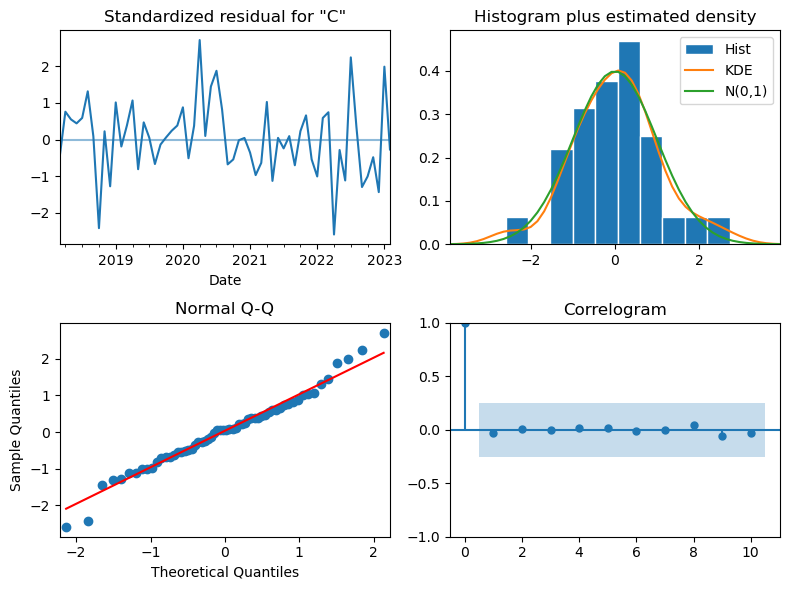

In [19]:
#Diagnostic Plots
results.plot_diagnostics(figsize=(8,6))
plt.tight_layout()
plt.show()

In [20]:
# Compute In-Sample Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Get in-sample predictions (log scale)
predictions = results.get_prediction(start=log_close.index[0], dynamic=False)
predicted_log = predictions.predicted_mean

# Convert to original scale and align with actual prices
predicted_prices = np.exp(predicted_log)
actual_prices = monthly_close.loc[predicted_log.index]

# Calculate metrics
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

print("\nModel Evaluation Metrics:")
print(f"MAE: ${mae:.2f}")
print(f"MSE: ${mse:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


Model Evaluation Metrics:
MAE: $9.48
MSE: $213.46
RMSE: $14.61
MAPE: 8.57%


# Forecast the Next 24 Months (2 years)

First 5 forecasted log values:
2023-03-31    4.570866
2023-04-30    4.555493
2023-05-31    4.568035
2023-06-30    4.543999
2023-07-31    4.536773
Freq: M, Name: predicted_mean, dtype: float64
First 5 forecasted original scale values:
2023-03-31    96.627771
2023-04-30    95.153637
2023-05-31    96.354555
2023-06-30    94.066180
2023-07-31    93.388955
Freq: M, Name: predicted_mean, dtype: float64


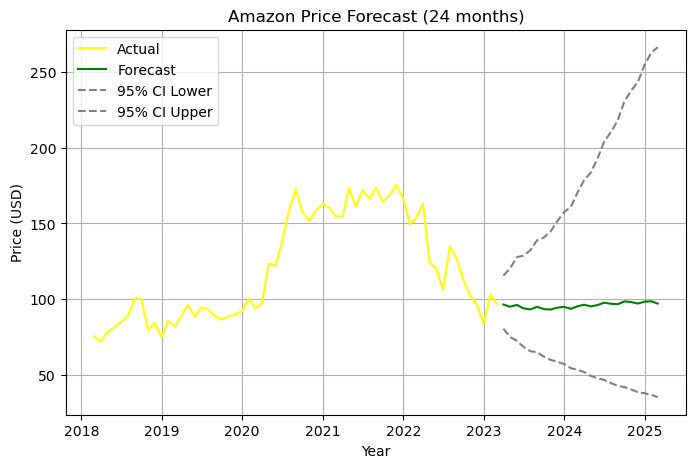

In [21]:
# Generate forecasts for the next 24 months (in log scale)
# Convert the forecast mean and confidence interval to original scale

def forecast_and_convert(model_results, steps):
    """
    Generate forecasts for a given number of steps ahead using a fitted ARIMA model,
    and convert results from log scale to original scale.
    
    Parameters:
    model_results (ARIMAResults): The fitted ARIMA model from which to forecast.
    steps (int): Number of future steps to forecast.
    
    Returns:
    tuple: Tuple containing the forecasted mean values and confidence intervals in both scales.
    """
    # Generate forecasts in log scale
    forecast_log = model_results.get_forecast(steps=steps)
    log_forecast_mean = forecast_log.predicted_mean  # predicted log values
    log_conf_int = forecast_log.conf_int()           # confidence intervals in log scale

    # Convert the forecast and confidence intervals to original scale
    forecast_mean = np.exp(log_forecast_mean)  # Convert mean to original scale
    conf_lower = np.exp(log_conf_int.iloc[:, 0])  # Convert lower bound
    conf_upper = np.exp(log_conf_int.iloc[:, 1])  # Convert upper bound

    # Optionally, print the first few values to check
    print("First 5 forecasted log values:")
    print(log_forecast_mean[:5])
    print("First 5 forecasted original scale values:")
    print(forecast_mean[:5])

    return (log_forecast_mean, log_conf_int, forecast_mean, conf_lower, conf_upper)


log_forecast_mean, log_conf_int, forecast_mean, conf_lower, conf_upper = forecast_and_convert(results, 24)
#plot actual vs forecast with intervals
plt.figure(figsize=(8,5))
plt.plot(monthly_close.index, monthly_close.values, label='Actual', color='yellow')
plt.plot(forecast_mean.index, forecast_mean.values, label='Forecast', color='green')
plt.plot(forecast_mean.index, conf_lower, color='gray', linestyle='--', label='95% CI Lower')
plt.plot(forecast_mean.index, conf_upper, color='gray', linestyle='--', label='95% CI Upper')
plt.title('Amazon Price Forecast (24 months)')
plt.xlabel('Year'); plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# LSTM and GRU Model Case Study on Amazon Stock Price Data Time Series Forecasting

In [22]:
#Data Preparation

import pandas as pd

# Load the CSV data
data = pd.read_csv("AMZN.csv")
# Parse 'Date' column to datetime and set as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Resample to monthly frequency using the last available closing price of each month
monthly_df = data['Close'].resample('M').last()

print("Date range:", monthly_df.index.min(), "to", monthly_df.index.max())
print("Number of monthly data points:", len(monthly_df))
print(monthly_df.head(3))  # show first 3 monthly prices


Date range: 2018-02-28 00:00:00 to 2023-02-28 00:00:00
Number of monthly data points: 61
Date
2018-02-28    75.622498
2018-03-31    72.366997
2018-04-30    78.306503
Freq: M, Name: Close, dtype: float64


# Stationarity Transformation (Log and Differencing) || Train-Test Split || Sliding Window || Feature Scaling 

In [23]:
# Apply log transformation to the monthly closing prices
log_series = np.log(monthly_df)

# Apply first-order differencing to the log-transformed series
diff_series = log_series.diff().dropna()

# Define the split point: last 24 months for testing
train_series = monthly_df.iloc[:-24]  # all data except last 24 points
test_series  = monthly_df.iloc[-24:]  # last 24 months for test

# Differenced log series for the training period and testing period
train_diff = diff_series[:train_series.index.max()]  # up to Feb 2021 diff
test_diff  = diff_series[test_series.index.min():]   # from Mar 2021 diff onward

window_size = 12
train_diff_values = train_diff.values  # numpy array of training differenced log values

X = []
y = []
# Sliding window: use past 12 values to predict the next value
for i in range(window_size, len(train_diff_values)):
    X.append(train_diff_values[i-window_size:i])  # 12 values
    y.append(train_diff_values[i])               # next value

X = np.array(X)
y = np.array(y)

from sklearn.preprocessing import StandardScaler

# Initialize scaler and fit on training differenced values (reshaped to column vector)
scaler = StandardScaler()
scaler.fit(train_diff_values.reshape(-1, 1))

# Transform the input sequences and target values
X_scaled = scaler.transform(X.reshape(-1, 1)).reshape(X.shape)
y_scaled = scaler.transform(y.reshape(-1, 1)).flatten()

print("Mean of training diffs (for scaling):", scaler.mean_[0])
print("Std of training diffs (for scaling):", np.sqrt(scaler.var_[0]))
print("First scaled input sample:\n", X_scaled[0])
print("First scaled target value:\n", y_scaled[0])

X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))
print("Reshaped X_scaled for RNN input:", X_scaled.shape)

Mean of training diffs (for scaling): 0.019871889878324406
Std of training diffs (for scaling): 0.08431030220061811
First scaled input sample:
 [-0.75762234  0.69989559  0.23564569  0.26440171  0.29405287  1.23870999
 -0.29305868 -2.9149332   0.42934428 -1.63590179  1.36325152 -0.7930817 ]
First scaled target value:
 0.7421408745953508
Reshaped X_scaled for RNN input: (24, 12, 1)


# Building and Training the RNN Models (LSTM & GRU)

In [24]:
#Building and Training the RNN Models (LSTM & GRU)
# Set random seeds for reproducibility
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Build GRU model
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train both models for a fixed number of epochs
epochs = 100
history_lstm = lstm_model.fit(X_scaled, y_scaled, epochs=epochs, verbose=0)
history_gru  = gru_model.fit(X_scaled, y_scaled, epochs=epochs, verbose=0)

# Print final training losses
print("LSTM final training loss:", history_lstm.history['loss'][-1])
print("GRU final training loss:", history_gru.history['loss'][-1])


LSTM final training loss: 0.29117095470428467
GRU final training loss: 0.23394377529621124


# Forecasting the Next 24 Months

In [25]:
def forecast(model, initial_log, initial_diffs, scaler, forecast_horizon, window_size):
    """Generalized function to perform forecasting using either LSTM or GRU."""
    predictions = []
    current_log = initial_log
    current_diffs = initial_diffs.copy()
    
    for _ in range(forecast_horizon):
        # Scale the input sequence and reshape for the model
        input_seq = scaler.transform(current_diffs.reshape(-1,1)).reshape(1, window_size, 1)
        # Predict the next log difference and reverse scaling
        pred_scaled_diff = model.predict(input_seq, verbose=0)
        pred_diff = scaler.inverse_transform(pred_scaled_diff)[0, 0]
        
        # Update the log price and calculate the actual price
        current_log += pred_diff
        predictions.append(np.exp(current_log))
        
        # Update the differences array for the next step
        current_diffs = np.concatenate([current_diffs[1:], [pred_diff]])
    
    return predictions

# Configuration
forecast_horizon = 24
window_size = 12  # Assuming window_size is defined as 12 for your models

# Fetch the last known log value and the last 12 differences from the training data
last_log = log_series[train_series.index.max()]
last_12_diffs = train_diff[-12:].values

# Forecast using both LSTM and GRU models
predictions_lstm = forecast(lstm_model, last_log, last_12_diffs, scaler, forecast_horizon, window_size)
predictions_gru = forecast(gru_model, last_log, last_12_diffs, scaler, forecast_horizon, window_size)

# Convert predictions to Pandas series for easy handling
forecast_dates = pd.date_range(start=train_series.index.max() + pd.DateOffset(months=1), periods=forecast_horizon, freq='M')
pred_series_lstm = pd.Series(predictions_lstm, index=forecast_dates)
pred_series_gru = pd.Series(predictions_gru, index=forecast_dates)

# Display the first few predictions from both models
print("First 3 Predictions LSTM:")
print(pred_series_lstm.head(3))
print("\nFirst 3 Predictions GRU:")
print(pred_series_gru.head(3))


First 3 Predictions LSTM:
2021-03-31    157.800017
2021-04-30    159.933243
2021-05-31    167.115431
Freq: M, dtype: float64

First 3 Predictions GRU:
2021-03-31    157.353646
2021-04-30    164.635985
2021-05-31    170.614576
Freq: M, dtype: float64


In [26]:
# Calculate evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convert test series to numpy array for compatibility
actual_prices = test_series.values
lstm_predictions = pred_series_lstm.values
gru_predictions = pred_series_gru.values

# LSTM Metrics
mae_lstm = mean_absolute_error(actual_prices, lstm_predictions)
mse_lstm = mean_squared_error(actual_prices, lstm_predictions)
rmse_lstm = np.sqrt(mse_lstm)
mape_lstm = np.mean(np.abs((actual_prices - lstm_predictions) / actual_prices)) * 100

# GRU Metrics
mae_gru = mean_absolute_error(actual_prices, gru_predictions)
mse_gru = mean_squared_error(actual_prices, gru_predictions)
rmse_gru = np.sqrt(mse_gru)
mape_gru = np.mean(np.abs((actual_prices - gru_predictions) / actual_prices)) * 100

print("\nModel Performance Comparison:")
print(f"{'Metric':<10} {'LSTM':<15} {'GRU':<15}")
print(f"{'MAE':<10} ${mae_lstm:.2f}{'':<8} ${mae_gru:.2f}")
print(f"{'MSE':<10} ${mse_lstm:.2f}{'':<8} ${mse_gru:.2f}")
print(f"{'RMSE':<10} ${rmse_lstm:.2f}{'':<8} ${rmse_gru:.2f}")
print(f"{'MAPE (%)':<10} {mape_lstm:.2f}%{'':<6} {mape_gru:.2f}%")


Model Performance Comparison:
Metric     LSTM            GRU            
MAE        $183.25         $109.67
MSE        $57985.83         $20478.13
RMSE       $240.80         $143.10
MAPE (%)   162.95%       98.57%


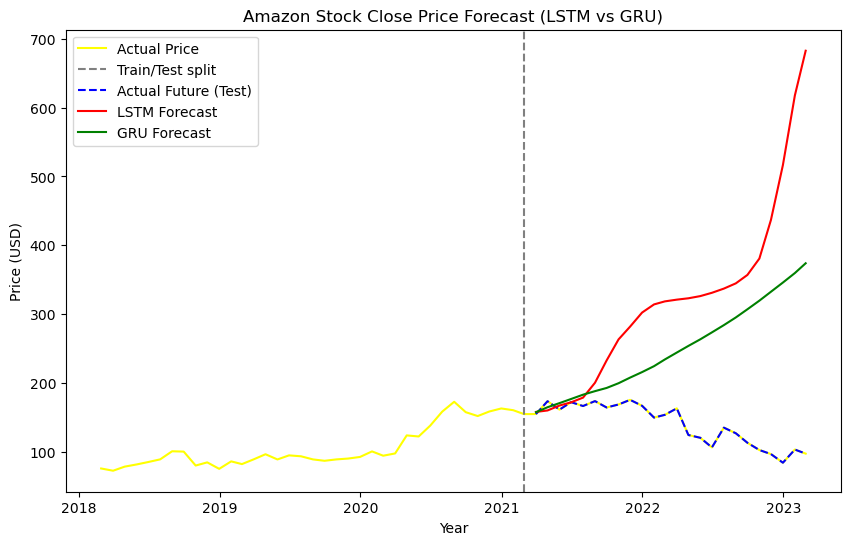

In [27]:
# Plot Amazon Stock Close Price Forecast (LSTM vs GRU)
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(monthly_df.index, monthly_df.values, label='Actual Price', color='yellow')
plt.axvline(x=train_series.index[-1], color='gray', linestyle='--', label='Train/Test split')
plt.plot(test_series.index, test_series.values, label='Actual Future (Test)', color='blue', linestyle='--')
plt.plot(pred_series_lstm.index, pred_series_lstm.values, label='LSTM Forecast', color='red')
plt.plot(pred_series_gru.index, pred_series_gru.values, label='GRU Forecast', color='green')
plt.title('Amazon Stock Close Price Forecast (LSTM vs GRU)')
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.show()
